In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import LSTM, Dense
from keras.layers import GRU 
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

2023-02-14 19:44:38.538208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#reading dataset
exchange_data = pd.read_csv('forex_data_10y.csv')
exchange_data.head()

,Date,Price,Open,High,Low,Volume,Chg%
0,25-Aug-20,74.327,74.100,74.335,74.075,0.92K,0.22%
1,24-Aug-20,74.168,74.922,74.922,73.962,4.90K,-1.01%
2,23-Aug-20,74.922,74.922,74.922,74.922,0,0.00%
3,21-Aug-20,74.920,74.980,75.005,74.820,3.16K,-0.12%
4,20-Aug-20,75.012,74.973,75.132,74.935,3.70K,0.22%


In [4]:
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

In [5]:
#checking first few records of the dataset
ind_exchange_data.head()

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2020-08-25,74.327,74.100,74.335,74.075,0.92K,0.22%
2020-08-24,74.168,74.922,74.922,73.962,4.90K,-1.01%
2020-08-23,74.922,74.922,74.922,74.922,0,0.00%
2020-08-21,74.920,74.980,75.005,74.820,3.16K,-0.12%
2020-08-20,75.012,74.973,75.132,74.935,3.70K,0.22%


In [6]:
# sorting the dataset in ascending order of date
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.head()

,Chg%,High,Low,Open,Price,Volume
Date,,,,,,
2010-09-13,0.05%,46.415,46.100,46.220,46.310,0
2010-09-14,-0.09%,46.465,46.070,46.270,46.270,0
2010-09-15,-0.15%,46.460,46.080,46.160,46.200,0
2010-09-16,-0.12%,46.415,46.075,46.145,46.145,0
2010-09-17,-0.63%,46.128,45.785,46.085,45.855,0


<AxesSubplot: xlabel='Date'>

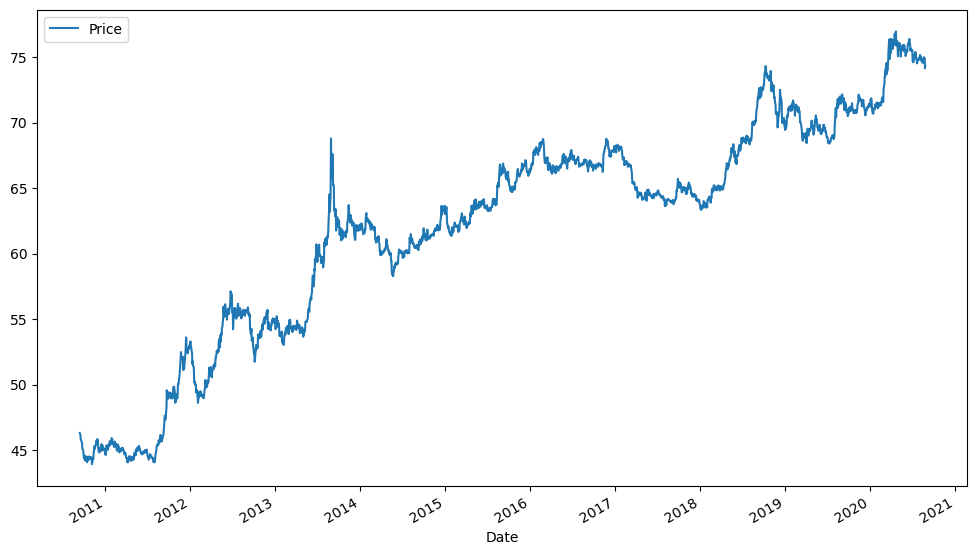

In [7]:
df = data_frame[["Price"]]

#plotting dataset to visualize the pattern of prices over the years

df.plot(kind='line',figsize=(12,7))

In [8]:
diff = df.index.values[-1] - df.index.values[0]



days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 2010 to %d"%(2010 + int(0.8*years)))

Total data: 9 years
80 percent data = 2010 to 2017


In [9]:
df.describe()

,Price
count,2598.000000
mean,61.972875
std,8.449870
min,43.925000
25%,55.460000
50%,64.017500
75%,67.836500
max,76.975000


             Price
Date              
2010-09-13  46.310
2010-09-14  46.270
2010-09-15  46.200
2010-09-16  46.145
2010-09-17  45.855
...            ...
2018-08-20  69.820
2018-08-21  69.860
2018-08-22  69.870
2018-08-23  70.105
2018-08-24  69.970

[2075 rows x 1 columns]
             Price
Date              
2018-08-27  70.165
2018-08-28  70.100
2018-08-29  70.535
2018-08-30  70.745
2018-08-31  71.005
...            ...
2020-08-20  75.012
2020-08-21  74.920
2020-08-23  74.922
2020-08-24  74.168
2020-08-25  74.327

[523 rows x 1 columns]


/var/folders/qs/tq01j0l577ddz8gg_tnvhl6m0000gn/T/ipykernel_6877/3712969271.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  split_date = pd.Timestamp('26-08-2018')


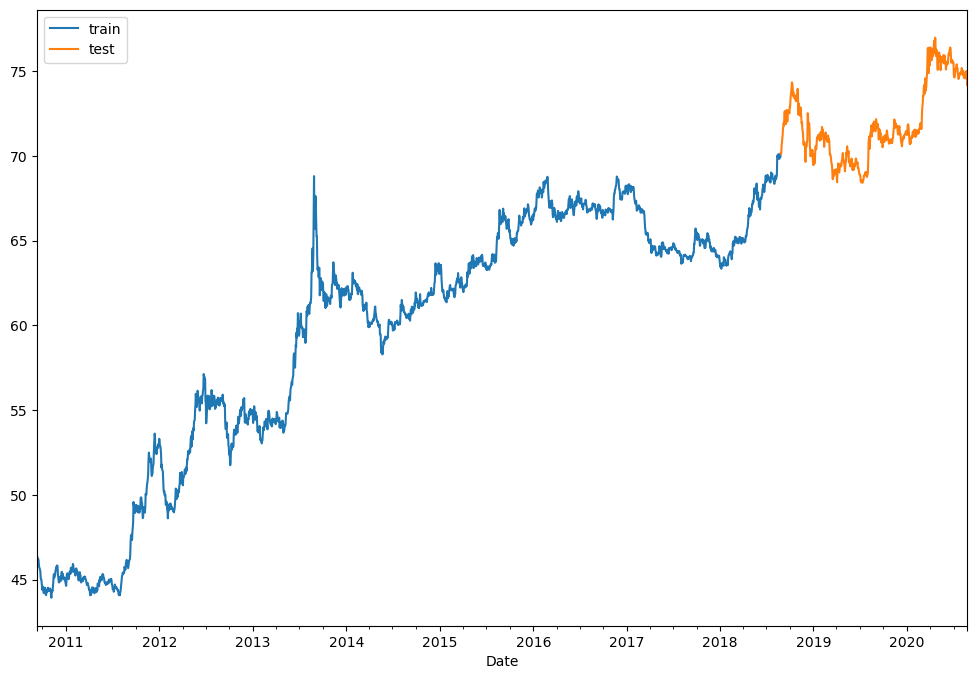

In [11]:
split_date = pd.Timestamp('26-08-2018')

train = df.loc[:split_date]
print(train)
test = df.loc[split_date:]
print(test)

ax = train.plot(kind='line',figsize=(12,8))
test.plot(ax=ax,kind='line',figsize=(12,8))
plt.legend(['train', 'test'])

In [135]:
print(train)

             Price
Date              
2010-09-13  46.310
2010-09-14  46.270
2010-09-15  46.200
2010-09-16  46.145
2010-09-17  45.855
...            ...
2018-08-20  69.820
2018-08-21  69.860
2018-08-22  69.870
2018-08-23  70.105
2018-08-24  69.970

[2075 rows x 1 columns]


In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [16]:
#use the previous price to predict the next 
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]


In [17]:
print(sc.inverse_transform(X_train[-3:]))
print(sc.inverse_transform(y_train[-3:]))

[[69.86 ]
 [69.87 ]
 [70.105]]
[[69.87 ]
 [70.105]
 [69.97 ]]


In [18]:
print(X_train.shape)
print(X_test.shape)

(2074, 1)
(522, 1)


In [19]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/200
2074/2074 [==============================] - 1s 557us/step - loss: 0.1785 - rmse: 0.4225
Epoch 2/200
2074/2074 [==============================] - 1s 558us/step - loss: 0.0053 - rmse: 0.0726
Epoch 3/200
2074/2074 [==============================] - 1s 528us/step - loss: 0.0025 - rmse: 0.0504
Epoch 4/200
2074/2074 [==============================] - 1s 529us/step - loss: 0.0022 - rmse: 0.0472
Epoch 5/200
2074/2074 [==============================] - 1s 565us/step - loss: 0.0021 - rmse: 0.0460
Epoch 6/200
2074/2074 [==============================] - 1s 567us/step - loss: 0.0019 - rmse: 0.0432
Epoch 7/200
2074/2074 [==============================] - 1s 564us/step - loss: 0.0019 - rmse: 0.0439
Epoch 8/200
2074/2074 [==============================] - 1s 548us/step - loss: 0.0018 - rmse: 0.0427
Epoch 9/200
2074/2074 [==============================] - 1s 543us/step - loss: 0.0017 - rmse: 0.0412
Epoch 10/200
2074/2074 [==============================] - 1s 554us/step - loss: 0.0017 - rm

In [21]:
#y pred_test is the actual ANN predictions
y_pred_test = model.predict(X_test)
y_train_pred = model.predict(X_train)

train_mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test)))
r2_test = r2_score(y_test, y_pred_test)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))


The R2 score on the Train set is:	0.973
The  MAE on the Train set is:	0.144
The  RMSE on the Train set is:	0.165
The Adjusted R2 score on the Train set is:	0.973

The R2 score on the Test set is:	0.952
The Adjusted R2 score on the Test set is:	0.952
The  MAE on the Test set is:	0.050
The  RMSE on the Test set is:	0.065


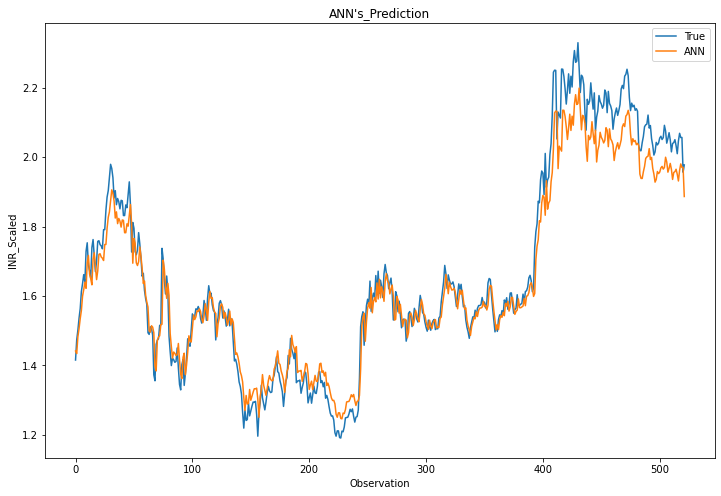

In [22]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test, label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()


In [23]:
last_value_ann = X_test[-1:]


future_predictions_ann = []
num_steps = 10

for i in range(num_steps):
    prediction_ann = model.predict(last_value_ann.reshape(1,-1))
    
    future_predictions_ann.append(prediction_ann[0][0])
    
    last_value_ann = np.concatenate((last_value_ann[1:], prediction_ann), axis=0)
    

inverse_transformed_data = sc.inverse_transform(future_predictions_ann).flatten().tolist()
print(inverse_transformed_data)






[73.64276885986328, 73.20342254638672, 72.83592987060547, 72.52852630615234, 72.27140045166016, 72.05631256103516, 71.87640380859375, 71.72591400146484, 71.60003662109375, 71.49473571777344]


In [24]:
X = []
y = []
timesteps = 5

for i in range(timesteps, train.shape[0]):
    X.append(train_sc[i-timesteps:i, 0])
    y.append(train_sc[i, 0])



X = np.array(X)
y = np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print(X.shape)
print(y.shape)



(2070, 5, 1)
(2070,)


In [35]:
model_lstm = Sequential()
model_lstm.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(64, activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             16896     
_________________________________________________________________
dropout (Dropout)            (None, 5, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#there may be a potiental error in this, change y_train???
history_model_lstm = model_lstm.fit(X, y, epochs=100, batch_size=192, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
11/11 [==============================] - 0s 9ms/step - loss: 0.9324 - rmse: 0.9656
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5939 - rmse: 0.7706
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2910 - rmse: 0.5395
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1431 - rmse: 0.3783
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0225 - rmse: 0.1499
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0267 - rmse: 0.1635
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0135 - rmse: 0.1162
Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0098 - rmse: 0.0991
Epoch 9/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0082 - rmse: 0.0904
Epoch 10/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0073 - rmse: 0.0852
Epoch 11/100
11/11 [==========================

In [27]:
X_test_lstm = []
Y_test_lstm = []

for i in range(timesteps, test.shape[0]):
    X_test_lstm.append(test_sc[i-timesteps:i, 0])
    Y_test_lstm.append(test_sc[i, 0])

    
X_test_lstm = np.array(X_test_lstm)
Y_test_lstm = np.array(Y_test_lstm)
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

y_pred_test_lstm = model_lstm.predict(X_test_lstm)







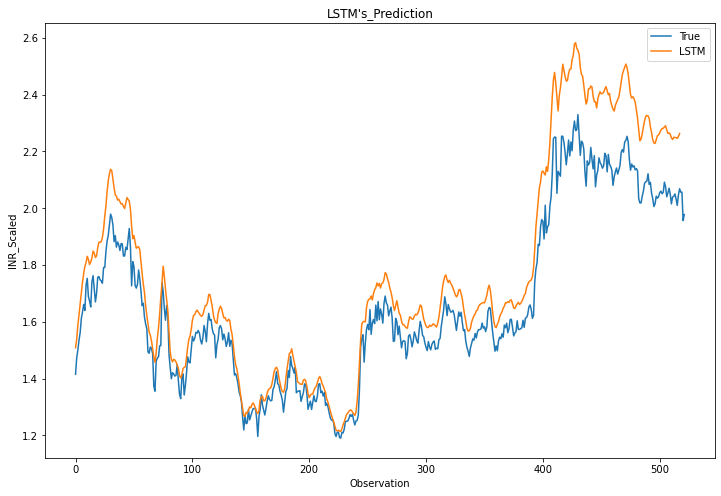

In [28]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [29]:
last_prediction = test_sc[-timesteps:]
last_prediction = np.array(last_prediction)

for i in range(10):
    next_input = np.array([last_prediction[-timesteps:]])
    next_input = next_input.reshape((next_input.shape[0], next_input.shape[1], 1))
    next_prediction = model_lstm.predict(next_input, verbose=0)
    last_prediction = np.append(last_prediction, next_prediction[0])
    

print(sc.inverse_transform(test_sc[-2:]))
print(sc.inverse_transform(last_prediction[-10:]))






[[74.168]
 [74.327]]
[76.3894995  76.37644519 76.52842921 76.82110743 77.65696484 78.71342564
 79.08498915 79.69650798 80.52110606 81.54756706]


In [77]:
K.clear_session()
model_gru = Sequential()
model_gru.add(GRU(16, input_shape=(X.shape[1],1), activation='linear', kernel_initializer='lecun_uniform', return_sequences=False))
model_gru.add(Dense(1))
model_gru.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 16)                912       
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


In [79]:
model_gru.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_gru = model_gru.fit(X, y, epochs=150, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/150
2070/2070 [==============================] - 2s 1ms/step - loss: 0.0038 - rmse: 0.0619
Epoch 2/150
2070/2070 [==============================] - 3s 1ms/step - loss: 0.0022 - rmse: 0.0472
Epoch 3/150
2070/2070 [==============================] - 2s 1ms/step - loss: 0.0023 - rmse: 0.0481
Epoch 4/150
2070/2070 [==============================] - 3s 1ms/step - loss: 0.0022 - rmse: 0.0473
Epoch 5/150
2070/2070 [==============================] - 2s 1ms/step - loss: 0.0022 - rmse: 0.0466
Epoch 6/150
2070/2070 [==============================] - 3s 1ms/step - loss: 0.0021 - rmse: 0.0456
Epoch 7/150
2070/2070 [==============================] - 2s 1ms/step - loss: 0.0020 - rmse: 0.0451
Epoch 8/150
2070/2070 [==============================] - 3s 1ms/step - loss: 0.0020 - rmse: 0.0443
Epoch 9/150
2070/2070 [==============================] - 2s 1ms/step - loss: 0.0019 - rmse: 0.0438
Epoch 10/150
2070/2070 [==============================] - 3s 1ms/step - loss: 0.0019 - rmse: 0.0432
Epoch 11/

In [80]:
y_pred_test_gru = model_gru.predict(X_test_lstm)


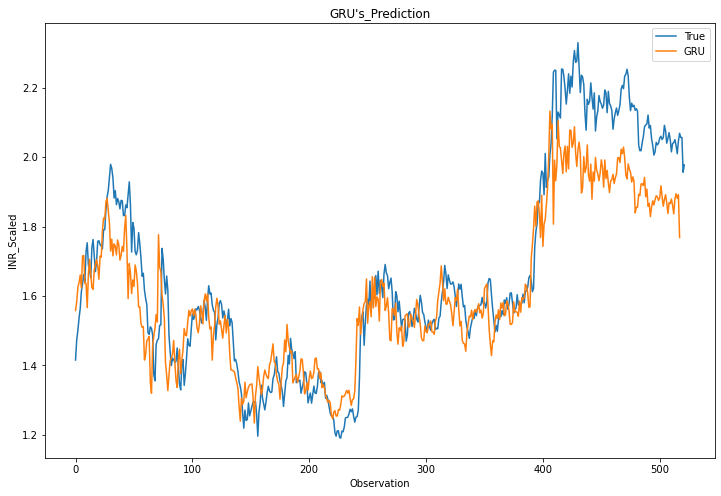

In [81]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_gru, label='GRU')
plt.title("GRU's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [126]:
K.clear_session()
model_hybrid = Sequential()
model_hybrid.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], 1)))
model_hybrid.add(LSTM(32, activation='relu',return_sequences=True))
model_hybrid.add(LSTM(16, activation='relu',return_sequences=True))
model_hybrid.add(GRU(16,  activation='linear', kernel_initializer='lecun_uniform', return_sequences=False))
model_hybrid.add(Dense(1))
model_hybrid.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 32)             12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 16)             3136      
_________________________________________________________________
gru (GRU)                    (None, 16)                1632      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 34,097
Trainable params: 34,097
Non-trainable params: 0
_________________________________________________________________


In [127]:
model_hybrid.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=7, verbose=1)
#there may be a potiental error in this, change y_train???
history_model_hybrid = model_hybrid.fit(X, y, epochs=500, batch_size=192, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/500
11/11 [==============================] - 0s 11ms/step - loss: 1.0162 - rmse: 1.0080
Epoch 2/500
11/11 [==============================] - 0s 11ms/step - loss: 0.9522 - rmse: 0.9758
Epoch 3/500
11/11 [==============================] - 0s 10ms/step - loss: 0.8961 - rmse: 0.9466
Epoch 4/500
11/11 [==============================] - 0s 10ms/step - loss: 0.7791 - rmse: 0.8827
Epoch 5/500
11/11 [==============================] - 0s 10ms/step - loss: 0.5115 - rmse: 0.7152
Epoch 6/500
11/11 [==============================] - 0s 10ms/step - loss: 0.1241 - rmse: 0.3523
Epoch 7/500
11/11 [==============================] - 0s 10ms/step - loss: 0.7086 - rmse: 0.8418
Epoch 8/500
11/11 [==============================] - 0s 10ms/step - loss: 0.1089 - rmse: 0.3300
Epoch 9/500
11/11 [==============================] - 0s 11ms/step - loss: 0.1663 - rmse: 0.4078
Epoch 10/500
11/11 [==============================] - 0s 11ms/step - loss: 0.1365 - rmse: 0.3694
Epoch 11/500
11/11 [===================

In [128]:
y_pred_test_hybrid = model_hybrid.predict(X_test_lstm)

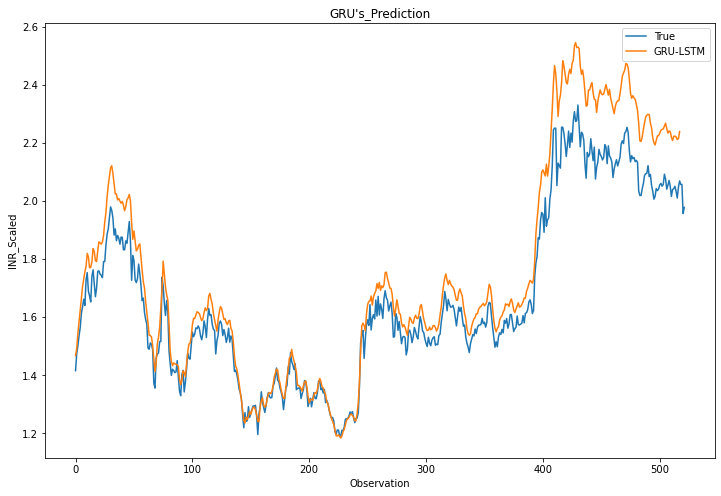

In [129]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_hybrid, label='GRU-LSTM')
plt.title("GRU's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()